In [38]:
from IPython.display import Image
from IPython.core.display import HTML
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
Image(url= "https://developer.spotify.com/assets/echonest-spotify.png")

In [39]:
# Need only first time
#conda install -c conda-forge python-dotenv
#conda install -c conda-forge pydot

In [113]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import sys
import pathlib

sys.path.insert(1, './fma_metadata/')
from fma_metadata import utils

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (13, 5)

-----------------
# Echonest EDA
-----------------
This dataset contains metrics provided by echonest. Those are private features computed using echonest algorithms.
The dataset has 3 main sub-datasets:
- audio_features
- metadata
- social_features
- temporal_features

## 1. Load Dataset
- echonest.csv: contains mid-level features for each track, provided by echonest;

In [41]:
echonest = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/echonest.csv')
echonest.shape

(13129, 249)

In [42]:
# check dataset
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

## 2. Data Understanding
---------
### Partition: Echonest - Audio Features
---------

In [43]:
print('**** Available data (%) ****\n echonest.csv - audio_features')
((abs(echonest['echonest','audio_features'].isnull().sum()-\
      echonest['echonest','audio_features'].shape[0])\
  /echonest['echonest','audio_features'].shape[0])*100).round(2).sort_values(ascending=False)

**** Available data (%) ****
 echonest.csv - audio_features


acousticness        100.0
danceability        100.0
energy              100.0
instrumentalness    100.0
liveness            100.0
speechiness         100.0
tempo               100.0
valence             100.0
dtype: float64

In [44]:
# load dataset - partition: audio_features
audio_features_dataset = echonest['echonest','audio_features'].copy()

## 3. Data Visualization
#### Audio features vs Top Genres

In [45]:
# load labels of top_genres
genre_labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/Data/Labels [generated]/labels_genre_top.csv')
genre_labels.set_index('track_id', inplace=True)
genre_labels.head()

genre_top
track_id          
2          Hip-Hop
3          Hip-Hop
5          Hip-Hop
10             Pop
20             NaN

In [46]:
# Attach genre_labels to echo_audiofeat
audio_features_dataset = audio_features_dataset.merge(genre_labels,on="track_id")
# display dataset
audio_features_dataset.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.416675      0.675894  0.634476          0.010628  0.177647   
3             0.374408      0.528643  0.817461          0.001851  0.105880   
5             0.043567      0.745566  0.701470          0.000697  0.373143   
10            0.951670      0.658179  0.924525          0.965427  0.115474   
134           0.452217      0.513238  0.560410          0.019443  0.096567   

          speechiness    tempo   valence genre_top  
track_id                                            
2            0.159310  165.922  0.576661   Hip-Hop  
3            0.461818  126.957  0.269240   Hip-Hop  
5            0.124595  100.260  0.621661   Hip-Hop  
10           0.032985  111.562  0.963590       Pop  
134          0.525519  114.290  0.894072   Hip-Hop

#### Correlation matrix

In [47]:
# Create a correlation matrix
corr_metrics = audio_features_dataset.corr()
corr_metrics.style.background_gradient()

#### Radar plot: Audio features vs Genres

In [48]:
# normalize dataset audio_features_dataset for visualization in radar plot
# the dataset audio_features_dataset_norm will be deleted after plotting
audio_features_dataset_norm = audio_features_dataset.copy()
audio_features_dataset_norm.iloc[:,0:8] = (audio_features_dataset_norm.iloc[:,0:8]\
                                           -audio_features_dataset_norm.iloc[:,0:8].min())\
                                          /(audio_features_dataset_norm.iloc[:,0:8].max()\
                                            -audio_features_dataset_norm.iloc[:,0:8].min())
audio_features_dataset_norm.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.418434      0.680869  0.634492          0.010649  0.159523   
3             0.375988      0.520349  0.817487          0.001855  0.084377   
5             0.043750      0.756819  0.701489          0.000698  0.364224   
10            0.955687      0.661557  0.924557          0.967346  0.094422   
134           0.454126      0.503556  0.560421          0.019481  0.074625   

          speechiness     tempo   valence genre_top  
track_id                                             
2            0.145135  0.642706  0.576663   Hip-Hop  
3            0.465638  0.479206  0.269236   Hip-Hop  
5            0.108355  0.367184  0.621664   Hip-Hop  
10           0.011296  0.414608  0.963599       Pop  
134          0.533129  0.426055  0.894080   Hip-Hop

In [49]:
genr_lst = audio_features_dataset_norm['genre_top'].unique().tolist()
colors = ["red", "green", "blue", "goldenrod", "magenta",'orange','purple',
          'black','lightblue','coral','darkgreen','brown']

for genre,color in zip(genr_lst,colors):
    metr = audio_features_dataset_norm[audio_features_dataset_norm['genre_top']==genre].describe().loc['mean'].tolist()
    theta=['acousticness','danceability','energy','instrumentalness',
           'liveness', 'tempo','speechiness','valence']

    fig = px.line_polar(audio_features_dataset_norm,
                        r=metr,
                        theta=theta,
                        line_close=True,
                        title=genre,
                        color_discrete_sequence=[color])
    fig.update_traces(fill='toself')
    fig.update_layout(
    title={
        'text': genre,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    fig.show()

#### Box plots: Audio Features

In [50]:
# boxplots - echonest features
tempo = go.Box(y=audio_features_dataset_norm['tempo'],name='tempo')
liveness = go.Box(y=audio_features_dataset_norm['liveness'],name='liveness')
acousticness = go.Box(y=audio_features_dataset_norm['acousticness'],name='acousticness')
danceability = go.Box(y=audio_features_dataset_norm['danceability'],name='danceability')
energy = go.Box(y=audio_features_dataset_norm['energy'],name='energy')
instrumentalness = go.Box(y=audio_features_dataset_norm['instrumentalness'],name='instrumentalness')
speechiness = go.Box(y=audio_features_dataset_norm['speechiness'],name='speechiness')
valence = go.Box(y=audio_features_dataset_norm['valence'], name='valence')


data = [acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence]
layout=go.Layout(title='Box-plots echonest features')
go.Figure(data=data, layout=layout)

-------
## Partition: Metadata
-------


-------
## Partition: Social Features
______

In [51]:
# load dataset
social_features_dataset = echonest['echonest','social_features']
social_features_dataset.head()

artist_discovery  artist_familiarity  artist_hotttnesss  \
track_id                                                            
2                 0.388990            0.386740           0.406370   
3                 0.388990            0.386740           0.406370   
5                 0.388990            0.386740           0.406370   
10                0.557339            0.614272           0.798387   
134               0.388990            0.386740           0.406370   

          song_currency  song_hotttnesss  
track_id                                  
2              0.000000         0.000000  
3              0.000000         0.000000  
5              0.000000         0.000000  
10             0.005158         0.354516  
134            0.000000         0.000000

### 1. Data Visualization
#### a) Artist familiarity vs Song hotness and currency

Text(0, 0.5, 'Song Hotness')

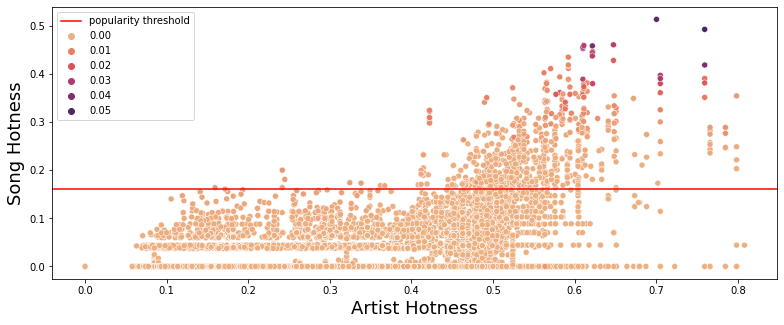

In [52]:
fig, ax= plt.subplots()
sns.scatterplot(x=social_features_dataset['artist_hotttnesss'],
                y=social_features_dataset['song_hotttnesss'],
                hue=social_features_dataset['song_currency'],
                palette="flare"
                )
ax.axhline(y=0.16, linestyle='-',color='red',label='popularity threshold')
plt.legend()
plt.xlabel("Artist Hotness", fontsize=18)
plt.ylabel("Song Hotness", fontsize=18)

Apart from tracks with 0 **artist_hotttnesss** and 0 **song_hotttnesss**, the two variable appear to be
positively correlated. As the artist gains familiarity among the audience, their song are considered to be hot. <br>
Should be interesting to create a label **song popularity** that takes value **"popular"** if the **artist_hotttnesss >0.4**
& **song_hotttnesss >0.15**.<br>
The hottess songs are the ones with high **song_currency** (> 0.2) as we can see from the graph.

#### b) Listens vs Song hotness

In [53]:
# importing data about listens from tracks.csv
tracks = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/tracks.csv')
track_listens = tracks['track'][['listens']]
social_features_dataset=social_features_dataset.merge(track_listens, on='track_id')
#social_features_dataset.head()

Text(0, 0.5, '#Listens')

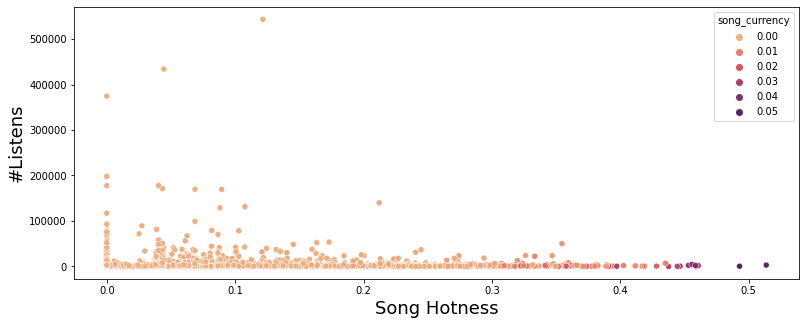

In [54]:
# plot relationship listens - song hotness
fig, ax= plt.subplots()
sns.scatterplot(x=social_features_dataset['song_hotttnesss'],
                y=social_features_dataset['listens'],
                hue=social_features_dataset['song_currency'],
                palette="flare"
                )
plt.xlabel("Song Hotness", fontsize=18)
plt.ylabel("#Listens", fontsize=18)

Tracks that are both current and hot have less than 100k listens. <br>
We can observe how songs that are not hot have more listens than current ones, probably due
to the fact that they've been out for a longer time. <br>
Tot number of listen doesn't appear to be a good estimator of a song popularity.

## 2. Feature engineering:$\;\;$ Song popularity
This label is determined by looking at the values in song_hotttnesss and artist_hotttnesss.<br><br>
We assigned label **popular** if song_hotttnesss & artist_hotttnesss were >= 0.15 and >= 0.4 respectively, else
we assigned the label **not popular**

In [55]:
# generating new label: song_popularity
social_features_dataset['song_popularity'] = np.where( ( (social_features_dataset['song_hotttnesss'] >= 0.15) & (social_features_dataset['artist_hotttnesss'] >= 0.4 ) ), 'popular', 'not popular')

In [56]:
#social_features_dataset.head()

In [57]:
social_features_dataset.song_popularity.value_counts()

not popular    12399
popular          730
Name: song_popularity, dtype: int64

In [58]:
# labels
song_popularity_labels = social_features_dataset[['song_popularity']]

# exporting labels: song_popularity
#with open("song_popularity_labels.csv","w") as new_label:
    #new_label.write(song_popularity_labels.to_csv(index=True))

## 3. Data Visualization of Echonest audio_features vs song_popularity
**What makes a song popular? What characteristics does it have? What genre is most popular?**

In [75]:
audio_features_dataset_norm = audio_features_dataset_norm.merge(song_popularity_labels, on='track_id')
audio_features_dataset_norm.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.418434      0.680869  0.634492          0.010649  0.159523   
3             0.375988      0.520349  0.817487          0.001855  0.084377   
5             0.043750      0.756819  0.701489          0.000698  0.364224   
10            0.955687      0.661557  0.924557          0.967346  0.094422   
134           0.454126      0.503556  0.560421          0.019481  0.074625   

          speechiness     tempo   valence genre_top song_popularity  
track_id                                                             
2            0.145135  0.642706  0.576663   Hip-Hop     not popular  
3            0.465638  0.479206  0.269236   Hip-Hop     not popular  
5            0.108355  0.367184  0.621664   Hip-Hop     not popular  
10           0.011296  0.414608  0.963599       Pop         popular  
134          0.533129  0.426055  0.894080   Hip-Hop     not popular

### a) Energy score for popular songs
Majority of popular songs have high values for energy (> 0.7)

<AxesSubplot:xlabel='energy', ylabel='Count'>

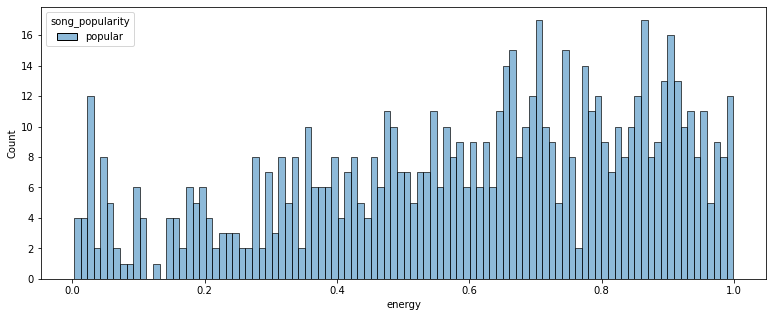

In [123]:
sns.histplot(audio_features_dataset_norm[audio_features_dataset_norm['song_popularity']=='popular'],x= 'energy',hue='song_popularity',bins=100 )

### b) Audio features vs song popularity$\;\;$Radar chart

In [125]:
metr0 = audio_features_dataset_norm[audio_features_dataset_norm['song_popularity']=='popular'].describe().loc['mean'].tolist()
metr1 = audio_features_dataset_norm[audio_features_dataset_norm['song_popularity']=='not popular'].describe().loc['mean'].tolist()
categories =['acousticness','danceability','energy','instrumentalness',
           'liveness', 'tempo','speechiness','valence']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=metr0,
      theta=categories,
      fill='toself',
      name='popular'
))
fig.add_trace(go.Scatterpolar(
      r=metr1,
      theta=categories,
      fill='toself',
      name='not popular'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.7]
    )),
  showlegend=True
)

fig.show()